In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('traffic.csv')

# Inspect the first few rows to verify column names and structure
print(df.head())
print("Data shape:", df.shape)


              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041
Data shape: (48120, 4)


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('traffic.csv')

# Inspect the first few rows to verify column names and structure
print(df.head())
print("Data shape:", df.shape)


              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041
Data shape: (48120, 4)


In [3]:
# Assuming that the dataset has a column named 'junction'.
# If the column name is different (e.g., 'Junction'), adjust accordingly.
df_junction1 = df[df['Junction'] == 1].reset_index(drop=True)
print("Filtered data shape (junction 1 only):", df_junction1.shape)


Filtered data shape (junction 1 only): (14592, 4)


In [4]:
import numpy as np

# Load the indices from the saved text files
train_idx = np.loadtxt("train_order_idx.txt", dtype=int)
val_idx   = np.loadtxt("val_order_idx.txt", dtype=int)
test_idx  = np.loadtxt("test_order_idx.txt", dtype=int)

# Re-create the training, validation, and test DataFrames from df_junction1
train_data = df_junction1.iloc[train_idx].reset_index(drop=True)
val_data   = df_junction1.iloc[val_idx].reset_index(drop=True)
test_data  = df_junction1.iloc[test_idx].reset_index(drop=True)

print("Train, Val, and Test sets created:")
print(" - Train data shape:", train_data.shape)
print(" - Validation data shape:", val_data.shape)
print(" - Test data shape:", test_data.shape)


Train, Val, and Test sets created:
 - Train data shape: (10214, 4)
 - Validation data shape: (1459, 4)
 - Test data shape: (2919, 4)


In [5]:
import pandas as pd

# Convert the DateTime column to datetime, if not already done
for d in [train_data, val_data, test_data]:
    d['DateTime'] = pd.to_datetime(d['DateTime'])

# Define the target column and feature columns
target_col = 'Vehicles'
# Remove target and DateTime columns from features list
feature_cols = [col for col in train_data.columns if col not in [target_col, 'DateTime']]

# Separate features and target for each split
X_train = train_data[feature_cols]
y_train = train_data[target_col]

X_val = val_data[feature_cols]
y_val = val_data[target_col]

X_test = test_data[feature_cols]
y_test = test_data[target_col]

# No scaling at this stage - we'll handle specific scaling later
print("Features and targets separated without scaling.")

Features and targets separated without scaling.



Torch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
Device name: NVIDIA GeForce GTX 1050 Ti
Starting training...
  -> Validation loss improved to 0.279482. Saving model.
Epoch 1/50 - Train Loss: 0.288967 - Val Loss: 0.279482 - Time: 10.07s
  -> Validation loss improved to 0.252193. Saving model.
Epoch 2/50 - Train Loss: 0.129350 - Val Loss: 0.252193 - Time: 9.68s
  -> Validation loss improved to 0.237042. Saving model.
Epoch 3/50 - Train Loss: 0.112099 - Val Loss: 0.237042 - Time: 9.82s
  -> Validation loss improved to 0.235231. Saving model.
Epoch 4/50 - Train Loss: 0.102822 - Val Loss: 0.235231 - Time: 10.24s
  -> Validation loss improved to 0.228813. Saving model.
Epoch 5/50 - Train Loss: 0.095697 - Val Loss: 0.228813 - Time: 9.70s
  -> Validation loss improved to 0.223238. Saving model.
Epoch 6/50 - Train Loss: 0.091984 - Val Loss: 0.223238 - Time: 9.65s
Epoch 7/50 - Train Loss: 0.089213 - Val Loss: 0.225913 - Time: 9.70s
  -> Validation loss improved to 0.222018. S

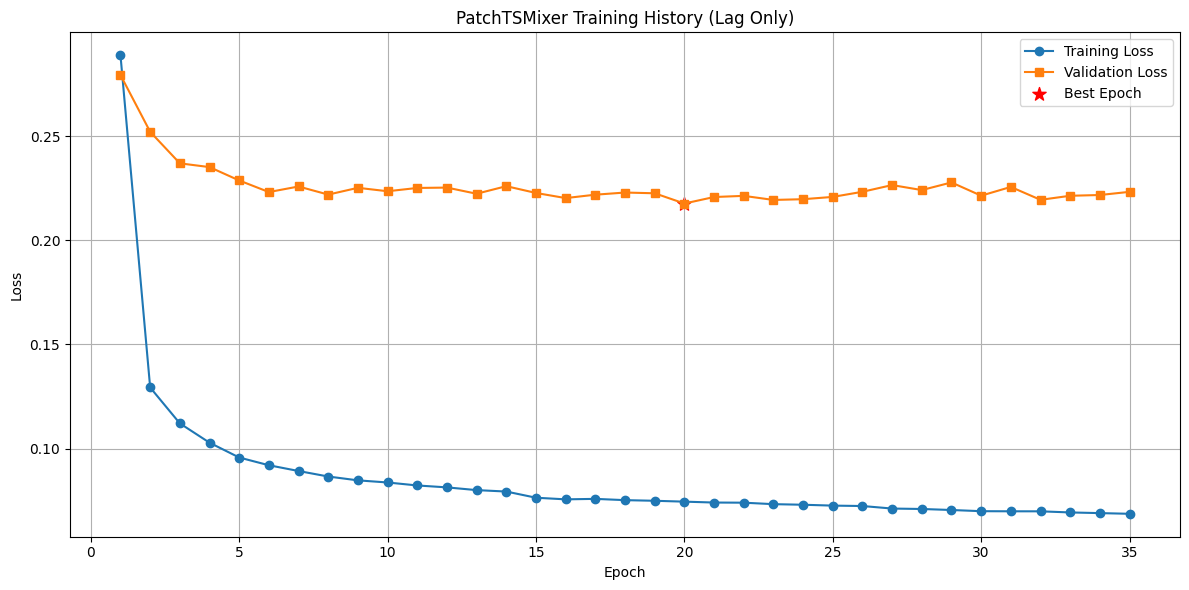


Loading best model from PatchTSMixer_lag_only_model_24h for evaluation...
Best model loaded successfully.


In [6]:
# GPU setup
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Removed StandardScaler as temp_scaler is no longer needed
from sklearn.preprocessing import QuantileTransformer
from transformers import PatchTSMixerConfig, PatchTSMixerForPrediction
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is NOT available. Using CPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Enhanced temporal features (Function kept for sorting, but features not used as input) ===
def extract_enhanced_datetime_features(df):
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    # Keep the function definition but we won't use the generated features below
    df['hour'] = df['DateTime'].dt.hour
    df['day_of_week'] = df['DateTime'].dt.dayofweek
    df['day'] = df['DateTime'].dt.day
    df['month'] = df['DateTime'].dt.month
    df['year'] = df['DateTime'].dt.year
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    df['is_workday'] = (~df['is_weekend']).astype(int)
    df['morning_rush'] = ((df['hour'] >= 7) & (df['hour'] <= 9)).astype(int)
    df['evening_rush'] = ((df['hour'] >= 16) & (df['hour'] <= 19)).astype(int)
    df['is_rush_hour'] = ((df['morning_rush'] | df['evening_rush']) & df['is_workday']).astype(int)
    return df

# temporal_features list is no longer needed for model input
# temporal_features = [ ... ] # Removed

# === Preprocess data ===
context_length = 168 # Use past 168 values
prediction_length = 24
# lags_sequence is not used by PatchTSMixer's core mechanism
# lags_sequence = [1, 2, 3, 4, 5, 6, 7] # Removed

# Sort data by DateTime (still useful)
# We apply the function but won't use the generated temporal features later
train_data_sorted = extract_enhanced_datetime_features(train_data.sort_values('DateTime').reset_index(drop=True))
val_data_sorted = extract_enhanced_datetime_features(val_data.sort_values('DateTime').reset_index(drop=True))
test_data_sorted = extract_enhanced_datetime_features(test_data.sort_values('DateTime').reset_index(drop=True))

# --- Target Scaling (Only scale the target 'Vehicles') ---
scaler = QuantileTransformer(output_distribution='normal', n_quantiles=min(1000, len(train_data_sorted))) # Adjusted n_quantiles
scaler.fit(train_data_sorted['Vehicles'].values.reshape(-1, 1))

train_scaled = scaler.transform(train_data_sorted['Vehicles'].values.reshape(-1, 1)).flatten()
val_scaled = scaler.transform(val_data_sorted['Vehicles'].values.reshape(-1, 1)).flatten()
# Scale test data as well for later evaluation
test_scaled = scaler.transform(test_data_sorted['Vehicles'].values.reshape(-1, 1)).flatten()

# --- Remove Temporal Feature Scaling ---
# temp_scaler = StandardScaler() # Removed
# train_temp_features = train_data_sorted[temporal_features].values # Removed
# temp_scaler.fit(train_temp_features) # Removed
# train_temp_scaled = temp_scaler.transform(train_temp_features) # Removed
# val_temp_scaled = temp_scaler.transform(val_data_sorted[temporal_features].values) # Removed
# test_temp_scaled = temp_scaler.transform(test_data_sorted[temporal_features].values) # Removed

# --- Prepare Data for Transformer (Modified to only use target values) ---
def prepare_transformer_data(values, context_length, prediction_length):
    """Prepares data sequences for PatchTSMixer using only target values."""
    past_values, future_values, past_observed_mask = [], [], []
    # Total length needed for one sample (context + prediction horizon)
    total_len_needed = context_length + prediction_length

    # Iterate through the values to create sequences
    for i in range(len(values) - total_len_needed + 1):
        # Past values: Slice the context window
        past_values.append(values[i : i + context_length])
        # Future values: Slice the prediction window
        future_values.append(values[i + context_length : i + total_len_needed])
        # Past observed mask: Array of ones indicating observed values
        past_observed_mask.append(np.ones(context_length, dtype=bool))

    return (
        np.array(past_values),
        np.array(past_observed_mask),
        np.array(future_values)
        # Removed past_time_features and future_time_features
    )

# max_lag is not needed here as context_length defines the history
# max_lag = max(lags_sequence) # Removed

# Prepare data using the modified function (only pass scaled target values)
train_past_vals, train_mask, train_future_vals = prepare_transformer_data(
    train_scaled, context_length, prediction_length
)
val_past_vals, val_mask, val_future_vals = prepare_transformer_data(
    val_scaled, context_length, prediction_length
)
# Prepare test data as well
test_past_vals, test_mask, test_future_vals = prepare_transformer_data(
    test_scaled, context_length, prediction_length
)


# Create tensors for PatchTSMixer
# PatchTSMixer expects past_values in shape [batch_size, seq_length, num_channels]
# We're using univariate data, so we reshape to have 1 channel
train_past_values_tensor = torch.tensor(train_past_vals, dtype=torch.float32).unsqueeze(-1).to(device)
train_future_values_tensor = torch.tensor(train_future_vals, dtype=torch.float32).unsqueeze(-1).to(device)
train_observed_mask_tensor = torch.tensor(train_mask, dtype=torch.bool).to(device) # Mask comes from index 1 now

val_past_values_tensor = torch.tensor(val_past_vals, dtype=torch.float32).unsqueeze(-1).to(device)
val_future_values_tensor = torch.tensor(val_future_vals, dtype=torch.float32).unsqueeze(-1).to(device)
val_observed_mask_tensor = torch.tensor(val_mask, dtype=torch.bool).to(device) # Mask comes from index 1 now

# Create test tensors
test_past_values_tensor = torch.tensor(test_past_vals, dtype=torch.float32).unsqueeze(-1).to(device)
test_future_values_tensor = torch.tensor(test_future_vals, dtype=torch.float32).unsqueeze(-1).to(device)
test_observed_mask_tensor = torch.tensor(test_mask, dtype=torch.bool).to(device)


# Create dataset and dataloader (only includes past values, mask, and future values)
train_dataset = TensorDataset(train_past_values_tensor, train_observed_mask_tensor, train_future_values_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# === PatchTSMixer Config (No changes needed here) ===
# Configure PatchTSMixer with parameters suited for our univariate time series
# === PatchTSMixer Config (No changes needed here) ===
config = PatchTSMixerConfig(
    context_length=context_length,
    prediction_length=prediction_length,  # <--- Ensure this matches above
    patch_length=12,
    patch_stride=12,
    num_input_channels=1,
    d_model=256,
    expansion_factor=2,
    num_layers=8,
    dropout=0.2,
    mode="common_channel",
    gated_attn=True,
    norm_mlp="LayerNorm",
    self_attn=True,
    self_attn_heads=4,
    use_positional_encoding=True,
    scaling="std",
    loss="mse",
    head_dropout=0.2
)

model = PatchTSMixerForPrediction(config).to(device)

# Training setup (No changes needed here)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# === Training (No changes needed in the loop logic) ===
print("Starting training...")
best_val_loss = float('inf')
patience = 15
patience_counter = 0
epochs = 50
train_losses, val_losses, epoch_times = [], [], []
# Ensure model_name is defined if you intend to save the model
model_name = "PatchTSMixer_lag_only_model_24h" # Example name

for epoch in range(epochs):
    model.train()
    epoch_start = time.time()
    epoch_loss = 0

    # The loader now yields batches of (past_values, mask, future_values)
    for past_batch, mask_batch, future_batch in train_loader:
        optimizer.zero_grad()

        # Forward pass with PatchTSMixer
        # The model call signature remains the same
        outputs = model(
            past_values=past_batch,
            # --- Add unsqueeze(-1) to match past_values shape ---
            observed_mask=mask_batch.unsqueeze(-1),
            future_values=future_batch # Provided for loss calculation
        )

        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        epoch_loss += loss.item() * past_batch.size(0) # Weighted average loss

    avg_train_loss = epoch_loss / len(train_dataset) # Average loss over the dataset
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        # Pass the validation tensors directly
        # The model call signature remains the same
        val_outputs = model(
            past_values=val_past_values_tensor,
            # --- Add unsqueeze(-1) to match past_values shape ---
            observed_mask=val_observed_mask_tensor.unsqueeze(-1),
            future_values=val_future_values_tensor # Provided for loss calculation
        )

        val_loss = val_outputs.loss.item()
        val_losses.append(val_loss)

    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model.save_pretrained(model_name) # Save the best model
        print(f"  -> Validation loss improved to {best_val_loss:.6f}. Saving model.")
        patience_counter = 0
    else:
        patience_counter += 1

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {val_loss:.6f} - Time: {epoch_time:.2f}s")

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# === Summary ===
print(f"\nTraining completed in {len(train_losses)} epochs")
if val_losses: # Check if validation was performed
    best_epoch_idx = val_losses.index(min(val_losses))
    print(f"Best validation loss: {min(val_losses):.6f} at epoch {best_epoch_idx + 1}")
    print(f"Final validation loss: {val_losses[-1]:.6f}")
else:
    print("No validation losses recorded.")


# === Plotting ===
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss', marker='o')
if val_losses: # Only plot validation if it exists
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss', marker='s')
    # Ensure best_epoch_idx is defined before using it
    if 'best_epoch_idx' in locals():
        plt.scatter(best_epoch_idx + 1, min(val_losses), c='red', s=100, label='Best Epoch', marker='*')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PatchTSMixer Training History (Lag Only)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Load the best model for evaluation
print(f"\nLoading best model from {model_name} for evaluation...")
# Check if the model was saved before trying to load
import os
if os.path.exists(model_name):
    model = PatchTSMixerForPrediction.from_pretrained(model_name).to(device)
    print("Best model loaded successfully.")
else:
    print(f"Warning: Model directory '{model_name}' not found. Using model from the last training epoch.")
    # Keep the 'model' variable as it is (from the end of training)

Loaded best model from PatchTSMixer_lag_only_model for evaluation.
Generating predictions on the test set using forward pass...
Shape of scaled predictions: (2728,)
Shape of original predictions: (2728,)
Shape of original targets: (65472,)

PatchTSMixer Last 24h RMSE: 14.08
PatchTSMixer Last 24h MAE: 10.80
PatchTSMixer Last 24h R2 Score: 0.55


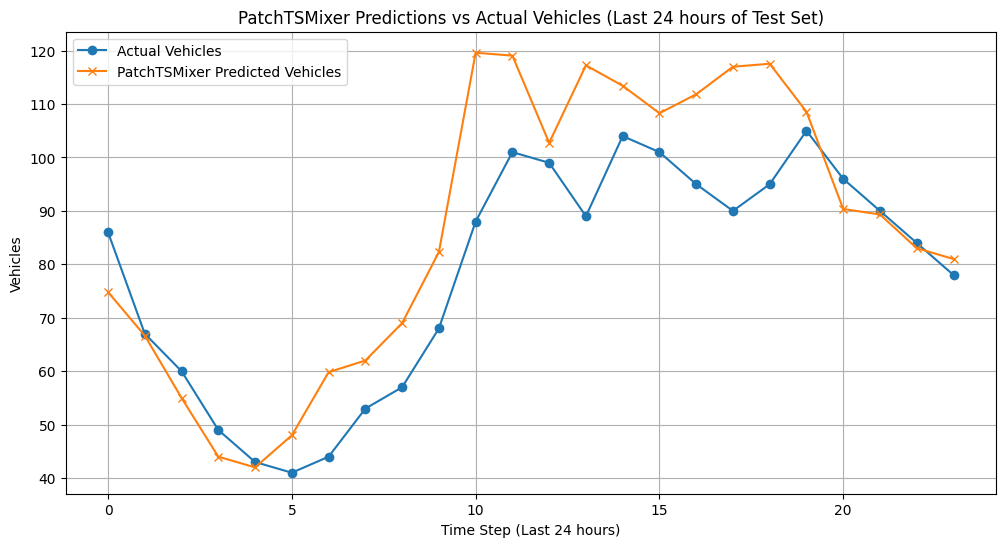

In [8]:
# === Evaluate PatchTSMixer Model ===
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import os

# Ensure the best model is loaded (or use the last trained one if save failed)
model_name = "PatchTSMixer_lag_only_model"
if os.path.exists(model_name):
    model = PatchTSMixerForPrediction.from_pretrained(model_name).to(device)
    print(f"Loaded best model from {model_name} for evaluation.")
else:
    print(f"Warning: Model directory '{model_name}' not found. Using model from the last training epoch for evaluation.")
    # Ensure the model is on the correct device if not loaded from file
    model.to(device)

# Set model to evaluation mode
model.eval()

# Store predictions
all_preds_scaled = []

# Predict on the test set using standard forward pass
with torch.no_grad():
    # Ensure the mask has the channel dimension added
    test_observed_mask_tensor_unsqueezed = test_observed_mask_tensor.unsqueeze(-1)

    # If test set is large, predict in batches
    test_dataset_eval = TensorDataset(test_past_values_tensor, test_observed_mask_tensor_unsqueezed)
    # Reduced batch size slightly, can adjust based on GPU memory
    test_loader_eval = DataLoader(test_dataset_eval, batch_size=128, shuffle=False)

    print("Generating predictions on the test set using forward pass...")
    for past_batch, mask_batch in test_loader_eval:
         # --- Use standard forward pass instead of generate ---
         outputs = model(
             past_values=past_batch,
             observed_mask=mask_batch
             # No future_values needed for prediction
         )
         # --- Get predictions from prediction_outputs ---
         # Shape is [batch_size, prediction_length, num_input_channels]
         # Assuming prediction_length=1, num_input_channels=1
         preds = outputs.prediction_outputs.squeeze().cpu().numpy()
         all_preds_scaled.append(preds)

# Concatenate predictions from all batches
patchtsmixer_test_pred_scaled = np.concatenate(all_preds_scaled)

# Ensure it's a 1D array if prediction_length was 1
if patchtsmixer_test_pred_scaled.ndim > 1 and patchtsmixer_test_pred_scaled.shape[1] == 1:
     patchtsmixer_test_pred_scaled = patchtsmixer_test_pred_scaled.flatten()
elif patchtsmixer_test_pred_scaled.ndim == 0: # Handle case where only one batch/item was processed
     patchtsmixer_test_pred_scaled = np.array([patchtsmixer_test_pred_scaled.item()])
# Handle case where test set size is smaller than batch size and squeeze removed all dims
elif patchtsmixer_test_pred_scaled.ndim == 1 and len(test_dataset_eval) < test_loader_eval.batch_size:
     pass # Already 1D, likely correct shape
# Add a check for unexpected shapes
elif patchtsmixer_test_pred_scaled.ndim != 1:
     print(f"Warning: Unexpected prediction shape after concatenation: {patchtsmixer_test_pred_scaled.shape}. Attempting to flatten.")
     patchtsmixer_test_pred_scaled = patchtsmixer_test_pred_scaled.flatten()


print(f"Shape of scaled predictions: {patchtsmixer_test_pred_scaled.shape}")

# Inverse transform the predictions to get the original scale
# Reshape needed for scaler's inverse_transform
patchtsmixer_test_pred_orig = scaler.inverse_transform(patchtsmixer_test_pred_scaled.reshape(-1, 1)).flatten()
patchtsmixer_test_pred_orig = np.clip(patchtsmixer_test_pred_orig, 0, None) # Ensure non-negative predictions

# Get the original actual test targets corresponding to the predictions
# These are the values that `test_future_vals` were derived from
y_test_orig = scaler.inverse_transform(test_future_vals.reshape(-1, 1)).flatten()
y_test_orig = np.clip(y_test_orig, 0, None) # Ensure non-negative targets

print(f"Shape of original predictions: {patchtsmixer_test_pred_orig.shape}")
print(f"Shape of original targets: {y_test_orig.shape}")

# Only compare the last 24 hours of predictions to the last 24 hours of actuals
# (or use the same prediction window length as your model output)

# Get the last 24 predictions and actuals for plotting and metrics
last_n = 24  # Change this if your prediction_length is different

patchtsmixer_test_pred_orig_24h = patchtsmixer_test_pred_orig[-last_n:]
y_test_orig_24h = y_test_orig[-last_n:]

# Calculate metrics for the last 24 hours
from sklearn.metrics import r2_score

if len(patchtsmixer_test_pred_orig_24h) == len(y_test_orig_24h) and len(y_test_orig_24h) > 0:
    patchtsmixer_rmse_24h = np.sqrt(mean_squared_error(y_test_orig_24h, patchtsmixer_test_pred_orig_24h))
    patchtsmixer_mae_24h = mean_absolute_error(y_test_orig_24h, patchtsmixer_test_pred_orig_24h)
    patchtsmixer_r2_24h = r2_score(y_test_orig_24h, patchtsmixer_test_pred_orig_24h)

    print(f"\nPatchTSMixer Last 24h RMSE: {patchtsmixer_rmse_24h:.2f}")
    print(f"PatchTSMixer Last 24h MAE: {patchtsmixer_mae_24h:.2f}")
    print(f"PatchTSMixer Last 24h R2 Score: {patchtsmixer_r2_24h:.2f}")

    plt.figure(figsize=(12, 6))
    plt.plot(y_test_orig_24h, label='Actual Vehicles', marker='o')
    plt.plot(patchtsmixer_test_pred_orig_24h, label='PatchTSMixer Predicted Vehicles', marker='x')
    plt.title('PatchTSMixer Predictions vs Actual Vehicles (Last 24 hours of Test Set)')
    plt.xlabel('Time Step (Last 24 hours)')
    plt.ylabel('Vehicles')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("\nCannot calculate metrics or plot: No matching predictions and targets found for the last 24 hours.")

In [9]:
# Calculate RMSE, MAE, and R2 for PatchTSMixer predictions on the last 20% of the dataset

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Get the last 20% of the original dataset as ground truth
n_total = len(df_junction1)
n_20 = int(n_total * 0.2)
actual_vehicles = df_junction1['Vehicles'].values[-n_20:]

# Get the last 20% of PatchTSMixer predictions (make sure to align shapes)
pred_vehicles = patchtsmixer_test_pred_orig[-n_20:]
if len(pred_vehicles) != len(actual_vehicles):
    min_len = min(len(pred_vehicles), len(actual_vehicles))
    pred_vehicles = pred_vehicles[:min_len]
    actual_vehicles = actual_vehicles[:min_len]

rmse = np.sqrt(mean_squared_error(actual_vehicles, pred_vehicles))
mae = mean_absolute_error(actual_vehicles, pred_vehicles)
r2 = r2_score(actual_vehicles, pred_vehicles)

print(f"\nPatchTSMixer Last 20% RMSE: {rmse:.2f}")
print(f"PatchTSMixer Last 20% MAE: {mae:.2f}")
print(f"PatchTSMixer Last 20% R2 Score: {r2:.2f}")


PatchTSMixer Last 20% RMSE: 10.18
PatchTSMixer Last 20% MAE: 7.77
PatchTSMixer Last 20% R2 Score: 0.81
